# Regularized Linear Models

Regularization helps to prevent overfitting.  Deeplearningbook.org states that regularization can be defined as any modification made to a learning algorithm that is intended to reduce its generalization error, but not its training error.

The no free lunch theorem states that there is no best machine learning algorithm and no best form of regularization.  Therefore, it is important to choose the form of regularization best suited for our specific problem.

<a href='http://shop.oreilly.com/product/0636920052289.do'>Hands on Machine Learning</a> states that for linear models, regularization is normally achieved by constraining the weights of the model.

Regularized linear models include ridge regression, lasso regression, and elastic net.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size':22})

## Ridge Regression

Ridge regression is a regularized version of linear regression.  The Thinkful curriculum states that ridge regression shrinks parameter estimates, but the estimates never reach exactly 0. (If alpha reaches 0 then ridge regression is just linear regression.)

It's important to remember to scale the data first. (ex: StandardScaler)

As alpha increases we get less extreme and more reasonable predictions.  This reduces variance, but also increases bias.

Options for running ridge regression are closed form and gradient descent.

## Lasso Regression
(Least Absolute Shrinkage and Selection Operator)

Lasso Regression works to eliminate the weight of the least important features by setting them equal to 0.  It automatically performs feature selection and outputs a sparse matrix.

Lasso is a good choice if we suspect only a few features may be useful.

## Elastic Net

Elastic Net is the middle ground between ridge and lasso regression.  When r=0 we have ridge regression and when r=1 lasso.

Elastic Net is generally preferred to lasso as lasso can behave erratically if features are highly correlated or when the number of features is greater than the number of training instances.

In [3]:
# Load the data. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


In [4]:
print(X_test2.columns)
X_train2.columns

Index(['default', 'student', 'balance', 'balance_student', 'balance_default',
       'student_default', 'balance_sqrt', 'balance2', 'balance3'],
      dtype='object')


Index(['default', 'student', 'balance', 'balance_student', 'balance_default',
       'student_default', 'balance_sqrt', 'balance2', 'balance3'],
      dtype='object')

In [5]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.44363376712897096

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


Checking predictive power using the test set:

In [6]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.44553225151184195
0.4380466345914476


In [68]:
# lasso cross validation to find best value for alpha

lasso_cv = linear_model.LassoCV().fit(X_train2, Y_train.ravel())
best_alpha = lasso_cv.alpha_   
best_alpha

4.9308953298481315

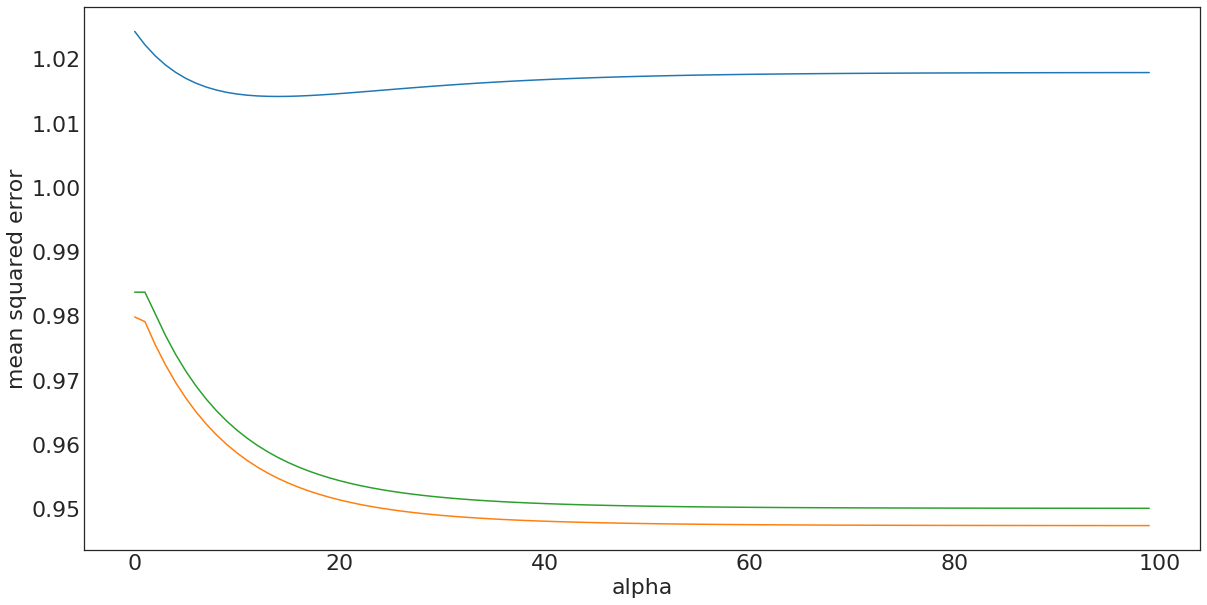

In [71]:
plt.plot(lasso_cv.mse_path_)
plt.xlabel('alpha')
plt.ylabel('mean squared error')
plt.show();

In [8]:
#early stopping

from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# SGDRegressor penalty (regularization parameter) l1 = lasso
# eta0 = initial learning rate (default 0.25)
# warm_start = reuse solution to previous call to fit as initialization
# max_iter impacts fit method = max number of passes over training data
# l1_ratio = elastic net mixing parameter - defaults to 0.15 1 corresponds to l1 penalty

sgd_reg = linear_model.SGDRegressor(warm_start=True,
                       penalty='l1',
                       l1_ratio=1,
                       alpha=best_alpha,             
                       learning_rate="constant",
                       eta0=0.0005,
                       max_iter=1
                       )

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train2, Y_train.ravel())
    y_ = sgd_reg.predict(X_train2)
    val_error = mean_squared_error(Y_train, y_)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [9]:
best_epoch, best_model

(299, SGDRegressor(alpha=4.9308953298481315, average=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=1,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, penalty='l1', power_t=0.25, random_state=None,
        shuffle=True, tol=None, verbose=0, warm_start=True))

In [10]:
best_model.fit(X_train2, Y_train.ravel())

print('\nR²:')
print(best_model.score(X_train2, Y_train))
origparams = np.append(best_model.coef_, best_model.intercept_)
print('\nParameter estimates:')
print(origparams)


R²:
-1.9156025178570342e+41

Parameter estimates:
[ 1.43050211e+10  7.91814000e+10  5.17677154e+10 -3.62196119e+10
  3.13178847e+10 -8.48404055e+10 -1.74126275e+10 -9.61068403e+12
 -4.36779639e+14 -1.99969620e+09]


In [11]:
print(best_model.score(X_test2, Y_test))

-1.9074340884852606e+41


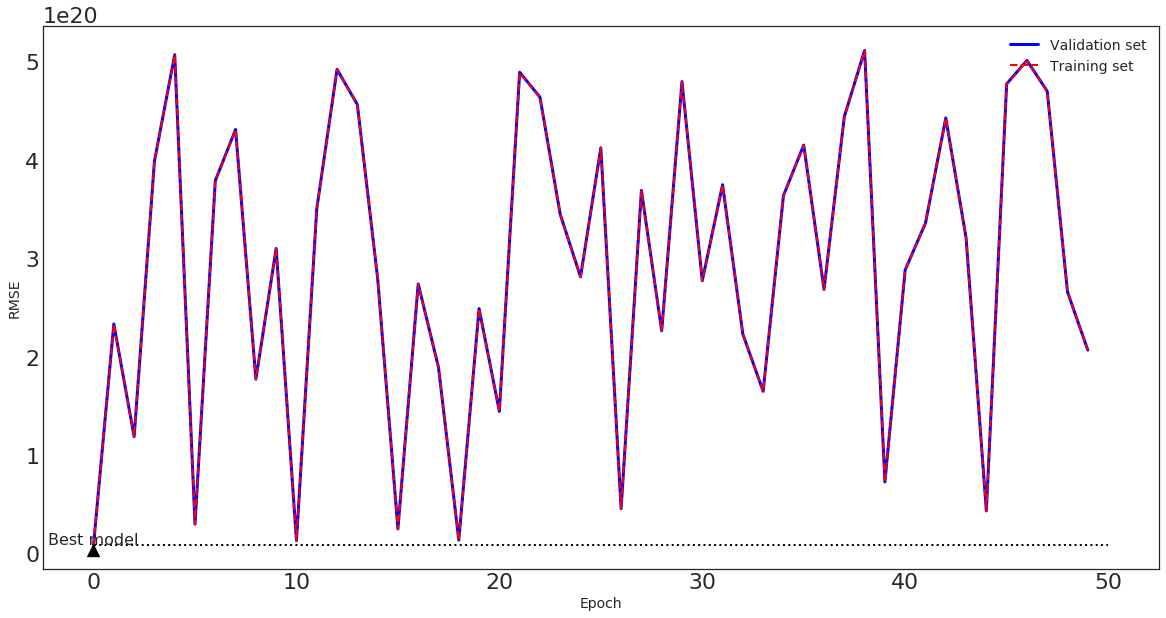

In [12]:
n_epochs = 50
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train2, Y_train.ravel())
    y_train_predict = sgd_reg.predict(X_train2)
    y_val_predict = sgd_reg.predict(X_test2)
    train_errors.append(mean_squared_error(Y_train, y_train_predict))
    val_errors.append(mean_squared_error(Y_train, y_val_predict))


best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )


best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [66]:
# ridge cross validation to find best value for alpha

ridge_cv = linear_model.RidgeCV(store_cv_values=True).fit(X_train2, Y_train.ravel())
ridge_alpha = ridge_cv.alpha_   
ridge_alpha 

10.0

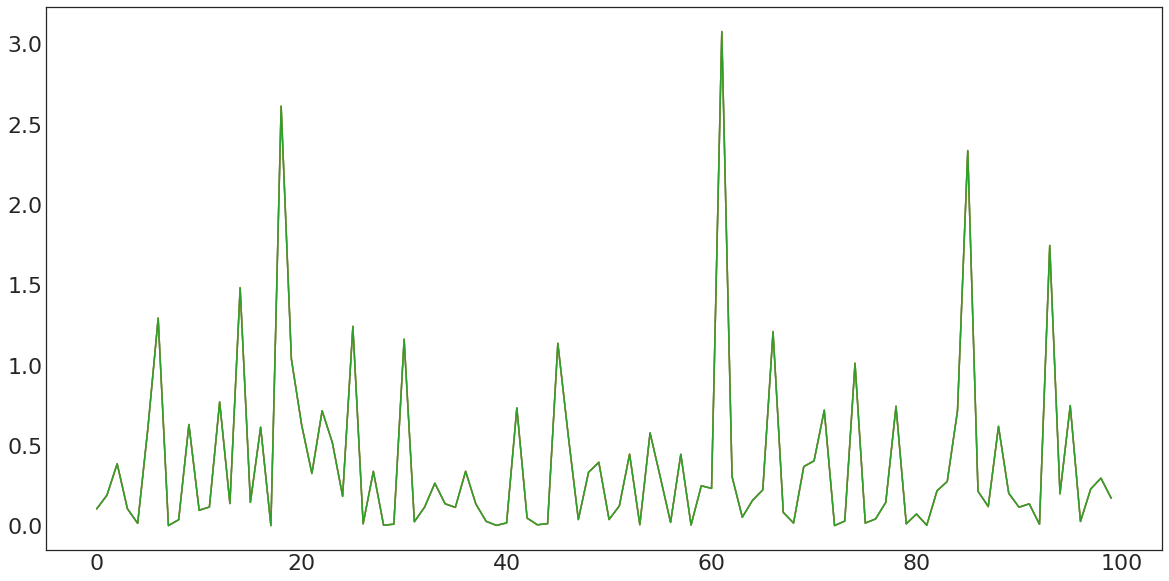

In [94]:
cv = ridge_cv.cv_values_

cv = pd.DataFrame(cv, columns=('samples', 'targets','alphas'))

plt.plot(cv.head(100))

In [57]:
ridge_alphas = ridge_cv.alphas_

scores = []

for a in ridge_alphas:
    ridge = linear_model.Ridge(alpha=a).fit(X_train2, Y_train.ravel())
    r2 = ridge.score(X_train2, Y_train)
    scores += score

scores

AttributeError: 'RidgeCV' object has no attribute 'alphas_'

In [15]:
from sklearn.base import clone
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# SGDRegressor penalty (regularization parameter) l2 = ridge
# eta0 = initial learning rate (default 0.25)
# warm_start = reuse solution to previous call to fit as initialization
# max_iter impacts fit method = max number of passes over training data
# l1_ratio = elastic net mixing parameter - defaults to 0.15 0 corresponds to l2 penalty

sgd_reg = SGDRegressor(warm_start=True,
                       alpha=ridge_alpha,
                       penalty='l2',
                       l1_ratio=0,
                       learning_rate="constant",
                       eta0=0.0005,
                       max_iter=1)

minimum_val_error = float("inf")
best_epoch = None
best_model = None



for epoch in range(1000):
    sgd_reg.fit(X_train2, Y_train.ravel())
    y_ = sgd_reg.predict(X_train2)
    val_error = mean_squared_error(Y_train, y_)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_ridge = clone(sgd_reg)

In [16]:
best_epoch, best_ridge

(537, SGDRegressor(alpha=10.0, average=False, epsilon=0.1, eta0=0.0005,
        fit_intercept=True, l1_ratio=0, learning_rate='constant',
        loss='squared_loss', max_iter=1, n_iter=None, penalty='l2',
        power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
        warm_start=True))

In [28]:
best_ridge.fit(X_train2, Y_train.ravel())
ridge_score = best_ridge.score(X_train2, Y_train)
print('\nR²:')
print(ridge_score)
origparams = np.append(best_ridge.coef_, best_ridge.intercept_)
print('\nParameter estimates:')
print(origparams)


R²:
-1.421100049193639e+40

Parameter estimates:
[-5.54705506e+09 -1.10685197e+09 -6.37946456e+09  1.98185874e+09
 -5.15953171e+09  2.39061730e+09  2.78923971e+09  1.83069912e+12
  1.18973634e+14 -1.31863239e+05]


In [18]:
print(best_ridge.score(X_test2, Y_test))

-3.7845610759254925e+40


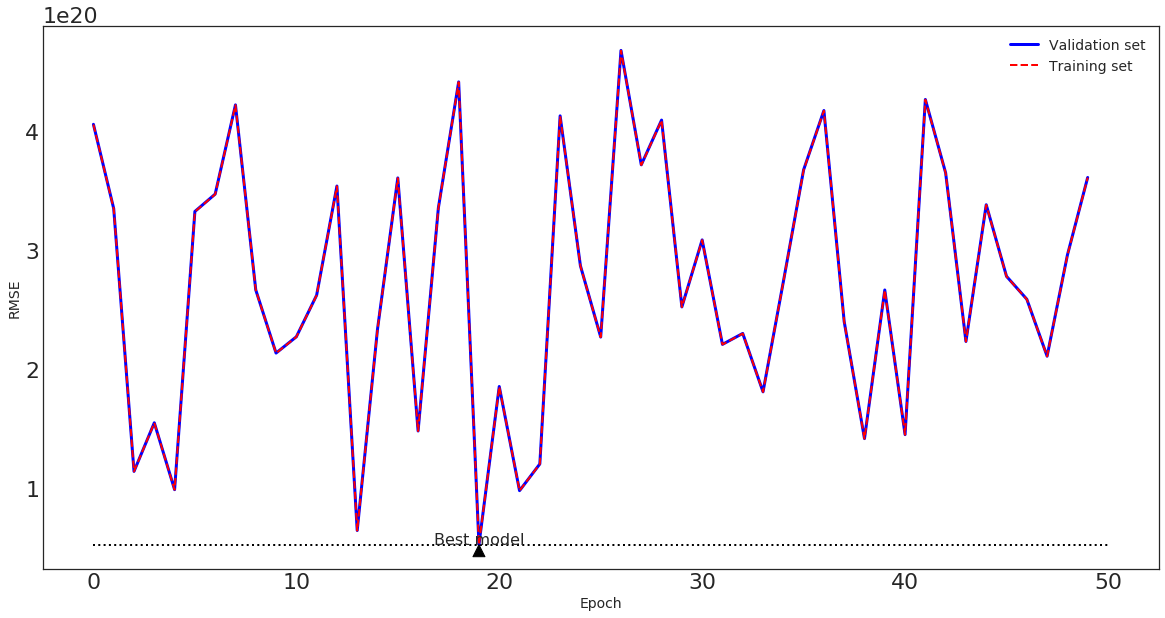

In [19]:
n_epochs = 50
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train2, Y_train.ravel())
    y_train_predict = sgd_reg.predict(X_train2)
    y_val_predict = sgd_reg.predict(X_test2)
    train_errors.append(mean_squared_error(Y_train, y_train_predict))
    val_errors.append(mean_squared_error(Y_train, y_val_predict))


best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size':22})

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [53]:
scores = np.array([ridge_score, ridge_alpha])
scores

array([-1.42110005e+40,  1.00000000e+01])

array([[(((((((((((((((((((((((array([-1.42110005e+40,  1.00000000e+01]), array([0.5739686, 1.       ])), array([0.57396003, 3.        ])), array([0.57395456, 5.        ])), array([0.57395075, 7.        ])), array([0.57394776, 9.        ])), array([ 0.57394517, 11.        ])), array([ 0.57394277, 13.        ])), array([ 0.57394044, 15.        ])), array([ 0.57393808, 17.        ])), array([ 0.57393567, 19.        ])), array([ 0.57393316, 21.        ])), array([ 0.57393053, 23.        ])), array([ 0.57392776, 25.        ])), array([ 0.57392485, 27.        ])), array([ 0.57392178, 29.        ])), array([ 0.57391855, 31.        ])), array([ 0.57391516, 33.        ])), array([ 0.57391159, 35.        ])), array([ 0.57390785, 37.        ])), array([ 0.57390394, 39.        ])), array([ 0.57389984, 41.        ])), array([ 0.57389557, 43.        ])), array([ 0.57389112, 45.        ])),
        array([ 0.57388649, 47.        ])],
       [0.5738816718999654, 49.0],
       [Ridge(alpha=1, copy_X=T